# Linear Regression - Through Scratch


---

## 1. About this Sprint

### Objective
- Understand linear regression **from scratch**.
- Practice **object-oriented** implementation in Python.
- Translate **formulas to code**.
- Learn by **training + validation**, then compare with a baseline (`scikit-learn`).


In [1]:
# Imports libraries
import os
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42) # random

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

## 2. Linear Regression from Scratch

### **Problem 4** — Mean Squared Error (MSE)


In [2]:
# First define MSE function for use in evaluation
def MSE(y_pred: np.ndarray, y: np.ndarray) -> float:
    """
    Compute Mean Squared Error (MSE).
    """
    y_pred = np.asarray(y_pred).reshape(-1)
    y = np.asarray(y).reshape(-1)
    return float(np.mean((y_pred - y) ** 2))

In [3]:
class ScratchLinearRegression:
    """
    Scratch implementation of Linear Regression trained via batch Gradient Descent.
    """

    def __init__(self, num_iter=1000, lr=0.01, no_bias=False, verbose=False):
        self.iter = int(num_iter)
        self.lr = float(lr)
        self.no_bias = bool(no_bias)
        self.verbose = bool(verbose)
        self.loss = np.zeros(self.iter, dtype=float)
        self.val_loss = np.zeros(self.iter, dtype=float)
        self.coef_ = None
        self.intercept_ = 0.0
        self.theta_ = None

    def _maybe_add_bias(self, X: np.ndarray) -> np.ndarray:
        """Add a column of ones as x0 for bias unless no_bias=True."""
        if self.no_bias:
            return X
        ones = np.ones((X.shape[0], 1), dtype=X.dtype)
        return np.hstack([ones, X])

    def _init_params(self, n_params: int):
        """Initialize parameters theta_ to zeros (stable for convex quadratic)."""
        self.theta_ = np.zeros(n_params, dtype=float)

    # Problem 1
    def _linear_hypothesis(self, X: np.ndarray) -> np.ndarray:
        """Compute the linear hypothesis h_theta(X) = X @ theta."""
        return (X @ self.theta_).reshape(-1)

    # Problem 5 - loss fn
    def _objective(self, y_pred: np.ndarray, y: np.ndarray) -> float:
        """J(theta) = (1/(2m)) * sum((h(x)-y)^2)."""
        return float(0.5 * np.mean((y_pred - y) ** 2))

    # Problem 2
    def _gradient_descent(self, X: np.ndarray, error: np.ndarray):
        """theta := theta - lr * (1/m) * X^T @ error"""
        m = X.shape[0]
        grad = (X.T @ error) / m
        self.theta_ -= self.lr * grad

    def fit(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None):
        """Train linear regression with batch Gradient Descent."""
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)
        X_aug = self._maybe_add_bias(X)
        self._init_params(X_aug.shape[1])

        for t in range(self.iter):
            y_pred = self._linear_hypothesis(X_aug)
            self.loss[t] = self._objective(y_pred, y)

            error = y_pred - y
            self._gradient_descent(X_aug, error)

            if X_val is not None and y_val is not None:
                Xv = self._maybe_add_bias(np.asarray(X_val, dtype=float))
                yv = np.asarray(y_val, dtype=float).reshape(-1)
                yv_pred = self._linear_hypothesis(Xv)
                self.val_loss[t] = self._objective(yv_pred, yv)

        if self.no_bias:
            self.intercept_ = 0.0
            self.coef_ = self.theta_.copy()
        else:
            self.intercept_ = float(self.theta_[0])
            self.coef_ = self.theta_[1:].copy()
        return self

    # Problem 3
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Return predictions using learned parameters."""
        X = np.asarray(X, dtype=float)
        X_aug = self._maybe_add_bias(X)
        return self._linear_hypothesis(X_aug)



## 3. Verification

### **Problem 6** - Learning & Estimation


In [5]:
# Load House Prices data - from Kaggle?

DATA_INFO = {} # Empty Dictionary

if os.path.exists("train.csv"):
    df = pd.read_csv("train.csv")
    y_all = df["SalePrice"].astype(float).values # target, in float format

    X_all = df.select_dtypes(include=[np.number]).drop(columns=["SalePrice"], errors="ignore").copy() # other variables (X)
    X_all = X_all.fillna(X_all.median(numeric_only=True)) # replace missing values with median
    feature_names = list(X_all.columns)

    n = len(y_all)
    idx = np.arange(n)
    np.random.shuffle(idx) # random selection
    split = int(0.8 * n) # 80% train data
    tr_idx, val_idx = idx[:split], idx[split:]

    X_train, y_train = X_all.iloc[tr_idx].values, y_all[tr_idx]
    X_val, y_val = X_all.iloc[val_idx].values, y_all[val_idx]

    DATA_INFO.update(source="House Prices (train.csv)", n_train=X_train.shape[0], n_val=X_val.shape[0], n_features=X_train.shape[1])

else:
    n_samples, n_features = 1200, 12 # random values if the dataset does not exist. This is not necessary
    X_all = np.random.randn(n_samples, n_features) # Just polishing my Linear Reg.
    true_w = np.random.uniform(-3, 3, size=n_features)
    true_b = 12.0
    noise = np.random.normal(0, 0.8, size=n_samples)
    y_all = X_all @ true_w + true_b + noise

    idx = np.arange(n_samples)
    np.random.shuffle(idx)
    split = int(0.8 * n_samples)
    tr_idx, val_idx = idx[:split], idx[split:]

    X_train, y_train = X_all[tr_idx], y_all[tr_idx]
    X_val, y_val = X_all[val_idx], y_all[val_idx]
    feature_names = [f"x{i}" for i in range(n_features)]

    DATA_INFO.update(source="Synthetic linear dataset", n_train=X_train.shape[0], n_val=X_val.shape[0], n_features=X_train.shape[1])

print(json.dumps(DATA_INFO, indent=2))

{
  "source": "House Prices (train.csv)",
  "n_train": 1168,
  "n_val": 292,
  "n_features": 37
}



### Train Scratch Model


In [6]:
def standardize_train_val(X_tr, X_va):
    mu = X_tr.mean(axis=0, keepdims=True)
    std = X_tr.std(axis=0, keepdims=True) + 1e-8
    return (X_tr - mu) / std, (X_va - mu) / std, (mu, std)

X_train_std, X_val_std, (mu_, std_) = standardize_train_val(X_train, X_val)

model = ScratchLinearRegression(num_iter=1000, lr=0.05, no_bias=False, verbose=False) # Model & Parameters
model.fit(X_train_std, y_train, X_val=X_val_std, y_val=y_val)

y_tr_pred = model.predict(X_train_std)
y_va_pred = model.predict(X_val_std)

mse_tr = MSE(y_tr_pred, y_train)
mse_va = MSE(y_va_pred, y_val)

print("Scratch model results")
print("  Intercept:", model.intercept_)
print("  Coef shape:", model.coef_.shape)
print(f"  Train MSE: {mse_tr:.4f}")
print(f"  Valid MSE: {mse_va:.4f}")

Scratch model results
  Intercept: 180965.13013698618
  Coef shape: (37,)
  Train MSE: 1110534499.4304
  Valid MSE: 1548911241.7774


In [7]:
print("First 5 train J values:", model.loss[:5])
print("Last 5  train J values:", model.loss[-5:])
if np.any(model.val_loss):
    print("First 5 val   J values:", model.val_loss[:5])
    print("Last 5  val   J values:", model.val_loss[-5:])

First 5 train J values: [1.95369345e+10 1.65242890e+10 1.44926860e+10 1.29415485e+10
 1.16577265e+10]
Last 5  train J values: [5.55267269e+08 5.55267265e+08 5.55267261e+08 5.55267257e+08
 5.55267253e+08]
First 5 val   J values: [1.63851649e+10 1.43323675e+10 1.27782959e+10 1.15016333e+10
 1.04030881e+10]
Last 5  val   J values: [7.74451136e+08 7.74452266e+08 7.74453391e+08 7.74454509e+08
 7.74455621e+08]


### Compare with scikit-learn


In [8]:
# Scikit Learn Linear Regression
sk_model = LinearRegression()
sk_model.fit(X_train_std, y_train)
y_tr_pred_sk = sk_model.predict(X_train_std)
y_va_pred_sk = sk_model.predict(X_val_std)

mse_tr_sk = MSE(y_tr_pred_sk, y_train)
mse_va_sk = MSE(y_va_pred_sk, y_val)

print("Baseline results (sklearn or normal equation)")
print(f"  Train MSE: {mse_tr_sk:.4f}")
print(f"  Valid MSE: {mse_va_sk:.4f}")

Baseline results (sklearn or normal equation)
  Train MSE: 1110533749.2093
  Valid MSE: 1549329790.8420


MSE Values are nearly similar. Let's proceed to plot 'em

### **Problem 7** - Plotting the Learning Curve


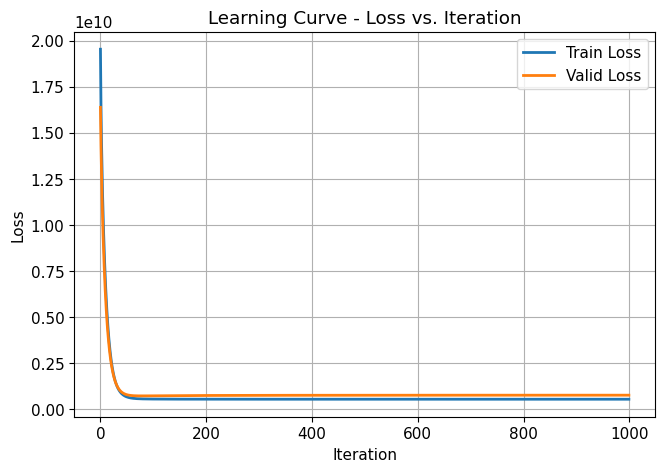

In [10]:
fig = plt.figure()
plt.plot(model.loss, label="Train Loss", linewidth=2.0, color="#1f77b4")
if np.any(model.val_loss):
    plt.plot(model.val_loss, label="Valid Loss", linewidth=2.0, color="#ff7f0e")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss vs. Iteration")
plt.legend()
plt.show()

### Diagnostic Plots


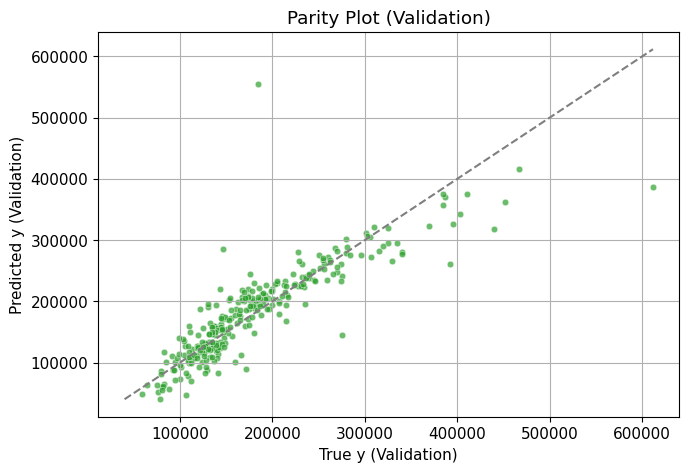

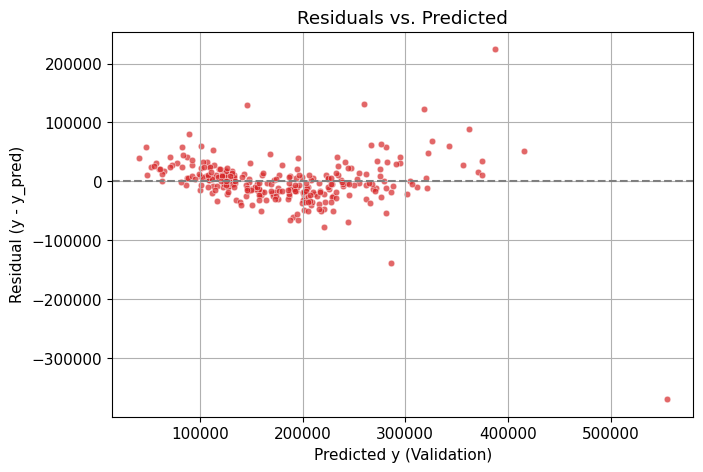

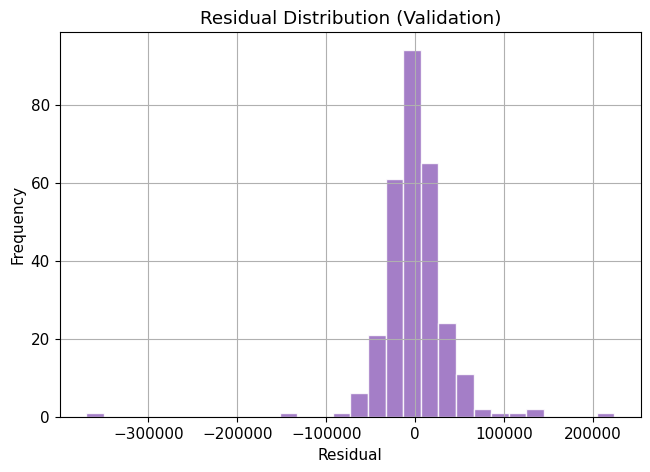

In [11]:
# Parity plot
fig = plt.figure()
plt.scatter(y_val, y_va_pred, s=22, alpha=0.7, edgecolor="white", linewidth=0.4, color="#2ca02c")
minv = min(y_val.min(), y_va_pred.min())
maxv = max(y_val.max(), y_va_pred.max())
plt.plot([minv, maxv], [minv, maxv], "--", color="#7f7f7f", linewidth=1.5)
plt.xlabel("True y (Validation)")
plt.ylabel("Predicted y (Validation)")
plt.title("Parity Plot (Validation)")
plt.show()

# Residual scatter
resid = y_val - y_va_pred
fig = plt.figure()
plt.scatter(y_va_pred, resid, s=22, alpha=0.7, edgecolor="white", linewidth=0.4, color="#d62728")
plt.axhline(0.0, linestyle="--", color="#7f7f7f", linewidth=1.5)
plt.xlabel("Predicted y (Validation)")
plt.ylabel("Residual (y - y_pred)")
plt.title("Residuals vs. Predicted")
plt.show()

# Residual histogram
fig = plt.figure()
plt.hist(resid, bins=30, alpha=0.85, edgecolor="white", color="#9467bd")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution (Validation)")
plt.show()

### **Problem 8** - Removing the Bias Term


In [12]:
model_nobias = ScratchLinearRegression(num_iter=1000, lr=0.05, no_bias=True, verbose=False)
model_nobias.fit(X_train_std, y_train, X_val=X_val_std, y_val=y_val)
y_va_pred_nb = model_nobias.predict(X_val_std)

print("Valid MSE (with bias):   ", f"{MSE(y_va_pred, y_val):.4f}")
print("Valid MSE (no bias):     ", f"{MSE(y_va_pred_nb, y_val):.4f}")

Valid MSE (with bias):    1548911241.7774
Valid MSE (no bias):      33960542766.8864



### **Problem 9** - Multidimensional Features


In [13]:
def add_poly_manual(X, degree=2):
    X = np.asarray(X, dtype=float)
    cols = [X]
    if degree >= 2:
        cols.append(X**2)
    if degree >= 3:
        cols.append(X**3)
    return np.hstack(cols)

degree = 2

try:
    from sklearn.preprocessing import PolynomialFeatures
    SKLEARN_AVAILABLE = True
except Exception as _:
    SKLEARN_AVAILABLE = False

if SKLEARN_AVAILABLE:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    Xtr_poly = poly.fit_transform(X_train_std)
    Xva_poly = poly.transform(X_val_std)
else:
    Xtr_poly = add_poly_manual(X_train_std, degree=degree)
    Xva_poly = add_poly_manual(X_val_std, degree=degree)

poly_model = ScratchLinearRegression(num_iter=1200, lr=0.03, no_bias=False, verbose=False)
poly_model.fit(Xtr_poly, y_train, X_val=Xva_poly, y_val=y_val)
y_va_poly = poly_model.predict(Xva_poly)
print(f"Valid MSE (base features):   {MSE(y_va_pred, y_val):.4f}")
print(f"Valid MSE (degree {degree}):  {MSE(y_va_poly, y_val):.4f}")

/tmp/ipython-input-1775122355.py:36: RuntimeWarning: overflow encountered in square
  return float(0.5 * np.mean((y_pred - y) ** 2))
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:127: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipython-input-1775122355.py:42: RuntimeWarning: invalid value encountered in matmul
  grad = (X.T @ error) / m
/tmp/ipython-input-1775122355.py:43: RuntimeWarning: invalid value encountered in subtract
  self.theta_ -= self.lr * grad


Valid MSE (base features):   1548911241.7774
Valid MSE (degree 2):  nan


### **Problem 10** - Deriving the Update Formula


### **Problem 11** - Why Linear Regression Finds the Global Optimum


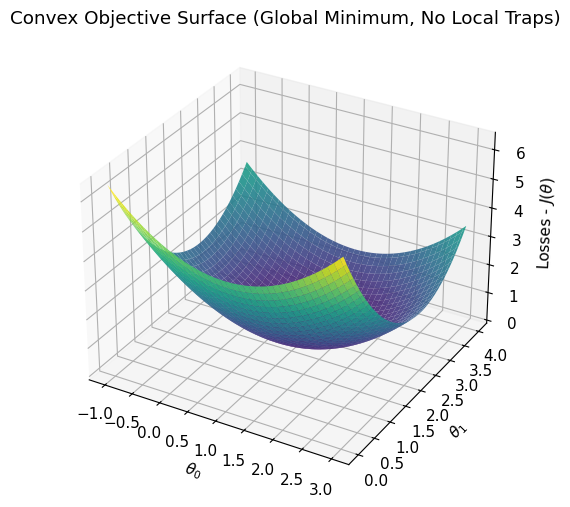

In [15]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np, matplotlib.pyplot as plt

# Simple 2D dataset for visualization
X_vis = np.c_[
    np.ones(50),      # bias
    np.linspace(-2, 2, 50)
]
theta_true = np.array([1.0, 2.5])
y_vis = X_vis @ theta_true + np.random.randn(50)*0.2

# Grid of theta0, theta1 to plot J(theta)
T0 = np.linspace(-1.0, 3.0, 80)
T1 = np.linspace(0.0, 4.0, 80)
TT0, TT1 = np.meshgrid(T0, T1)
Jsurf = np.zeros_like(TT0)

for i in range(TT0.shape[0]):
    for j in range(TT0.shape[1]):
        theta = np.array([TT0[i, j], TT1[i, j]])
        y_hat = X_vis @ theta
        Jsurf[i, j] = 0.5 * np.mean((y_hat - y_vis) ** 2)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(TT0, TT1, Jsurf, cmap="viridis", edgecolor="none", alpha=0.9)
ax.set_xlabel(r"$\theta_0$")
ax.set_ylabel(r"$\theta_1$")
ax.set_zlabel(r"Losses - $J(\theta)$")
ax.set_title("Convex Objective Surface (Global Minimum, No Local Traps)")
plt.show()


### K-Fold Cross-Validation (Scratch Model)


In [16]:
# Trial
def kfold_indices(n, n_splits=5, shuffle=True, random_state=42):
    idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(random_state)
        rng.shuffle(idx)
    fold_sizes = np.full(n_splits, n // n_splits, dtype=int)
    fold_sizes[: n % n_splits] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(idx[start:stop])
        current = stop
    for k in range(n_splits):
        val_idx = folds[k]
        train_idx = np.hstack([folds[i] for i in range(n_splits) if i != k])
        yield train_idx, val_idx

# Use standardized base features for CV
X_base = np.vstack([X_train_std, X_val_std])
y_base = np.hstack([y_train, y_val])

kf_mse = []
for train_idx, val_idx in kfold_indices(len(y_base), n_splits=5, shuffle=True, random_state=123):
    Xtr, Xva = X_base[train_idx], X_base[val_idx]
    ytr, yva = y_base[train_idx], y_base[val_idx]
    m = ScratchLinearRegression(num_iter=400, lr=0.05, no_bias=False, verbose=False)
    m.fit(Xtr, ytr, X_val=Xva, y_val=yva)
    kf_mse.append(MSE(m.predict(Xva), yva))

print("5-Fold CV MSE (Scratch):", [f"{v:.4f}" for v in kf_mse])
print("Mean CV MSE:", f"{np.mean(kf_mse):.4f}")

5-Fold CV MSE (Scratch): ['1522033149.9998', '2791206249.7274', '1038330431.8877', '716351325.5444', '1561511280.3423']
Mean CV MSE: 1525886487.5003



### Predict on `test.csv` - Optional


In [17]:
if os.path.exists("test.csv") and os.path.exists("train.csv"):
    test_df = pd.read_csv("test.csv")
    num_cols = pd.read_csv("train.csv").select_dtypes(include=[np.number]).drop(columns=["SalePrice"], errors="ignore").columns
    X_test = test_df[num_cols].copy()
    X_test = X_test.fillna(X_test.median(numeric_only=True))
    X_test_std = (X_test.values - mu_) / std_
    y_test_pred = model.predict(X_test_std)
    sub = pd.DataFrame({
        "Id": test_df["Id"] if "Id" in test_df.columns else np.arange(len(X_test)),
        "SalePrice": y_test_pred
    })
    out_path = "submission.csv"
    sub.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")
else:
    print("No test.csv detected — skipping submission generation.")

Saved: submission.csv



---

## Conclusion

- All problems are implemented and explicitly labeled above.
